# USAGE:
### - notebook for quick development of new features, any changes made here should be implemneted into the raw .py files and the GUI notebook for inclusion in the project.

#### Imports

In [1]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt
import scipy
import copy
import random
import os
import datetime

# Machine learning tools
import umap
from sklearn.linear_model import LinearRegression
import torch
import torch.utils.data
from torch import optim
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import TensorDataset
from sklearn.model_selection import ShuffleSplit

# File load and save imports
from utils import *
import segypy 
import pickle

# widget imports
from ipywidgets import interact, VBox, HBox
import ipywidgets as widgets
from IPython.display import clear_output

# Tensor board
from tensorboardX import SummaryWriter

# live loss plots
from livelossplot import PlotLosses

#### Copy paste "utils.py" because it wont load/import:

In [2]:
#utils
"""
utils module containing various support functions for the running of the main processes

"""


# standard imports
import numpy as np
import random
import scipy

# pytorch
import torch
from torch.autograd import Variable
import torch.nn as nn

# segy load and save tool
import segypy



def set_seed(seed):
    """
    Set random seed for all relevant randomisation tools.

    Parameters
    ----------
    seed : int
        Random seed value

    Returns
    -------
    None
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled = False

    return True


def load_seismic(filename, inlines=[1300, 1502, 2], xlines=[1500, 2002, 2]):
    """
    Load seismic amplitudes from .SEGY into numpy array.

    Parameters
    ----------
    filename : str
        File pathname for .SEGY file.
    inlines : list
        List in form [start, stop, step] for data inlines.
    xlines : list
        List in form [start, stop, step] for data inlines.

    Returns
    -------
    amplitude : array_like
        Array of seismic amplitudes.
    twt : array_like
        Array of twt range for data.

    """
    inl = np.arange(*inlines)
    crl = np.arange(*xlines)
    seis, header, trace_headers = segypy.readSegy(filename)
    amplitude = seis.reshape(header['ns'], inl.size, crl.size)
    lagtime = trace_headers['LagTimeA'][0] * -1
    twt = np.arange(lagtime, header['dt'] / 1e3 * header['ns'] + lagtime,
                    header['dt'] / 1e3)
    return amplitude, twt


def load_horizon(filename, inlines=[1300, 1502, 2], xlines=[1500, 2002, 2]):
    """
    Load horizon from .txt into numpy array.

    Parameters
    ----------
    filename : str
        File pathname to .txt file
    inlines : list
        List in form [start, stop, step] for data inlines.
    xlines : list
        List in form [start, stop, step] for data inlines.

    Returns
    -------
    Numpy array of horizon depth.

    """
    inl = np.arange(*inlines)
    crl = np.arange(*xlines)
    hrz = np.recfromtxt(filename, names=['il', 'xl', 'z'])
    horizon = np.zeros((len(inl), len(crl)))
    for i, idx in enumerate(inl):
        for j, xdx in enumerate(crl):
            time = hrz['z'][np.where((hrz['il'] == idx) & (hrz['xl'] == xdx))]
            if len(time) == 1:
                horizon[i, j] = time

    return horizon


def interpolate_horizon(horizon):
    """
    Interpolates missing data in a horizon numpy array.

    Parameters
    ----------
    horizon : array_like
        horizon depth data.

    Returns
    -------
    Interpolated array for full field coverage.

    """

    points = []
    wanted = []
    for i in range(horizon.shape[0]):
        for j in range(horizon.shape[1]):
            if horizon[i, j] != 0.:
                points.append([i, j, horizon[i, j]])
            else:
                wanted.append([i, j])

    points = np.array(points)
    zs2 = scipy.interpolate.griddata(points[:, 0:2],
                                     points[:, 2],
                                     wanted,
                                     method="cubic")
    for p, val in zip(wanted, zs2):
        horizon[p[0], p[1]] = val

    return horizon


class VAE(nn.Module):
    """
    Pytorch compatible vae model implementation.
    """
    def __init__(self, hidden_size, shape_in):
        """
        Define the architecture of VAE model.

        Parameters
        ----------
        hidden_size : int
            Size of the vae latent space.
        shape_in : int
            Size of the input dimension.
        """
        super(VAE, self).__init__()

        #  Architecture paramaters
        shape = shape_in[-1]

        assert shape % 4 == 0, 'input dimension for VAE must be factor of 4'
        reductions = [0.5, 0.5,
                      0.5]  # specified reduction factor of each convolution

        self.last_conv_channels = 34  # number of channels after last convolution

        # find the resultant dimension post convolution layer processing
        post_conv = self.post_conv_dim(shape, reductions,
                                       self.last_conv_channels)

        self.linear_dimension = post_conv * self.last_conv_channels

        # Encoder
        self.conv1 = nn.Conv1d(2, 3, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(32, 32, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv1d(32, self.last_conv_channels, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(self.linear_dimension, 128)

        # Latent space
        self.fc21 = nn.Linear(128, hidden_size)
        self.fc22 = nn.Linear(128, hidden_size)

        # Decoder
        self.fc3 = nn.Linear(hidden_size, 128)
        self.fc4 = nn.Linear(128, self.linear_dimension)
        self.deconv1 = nn.ConvTranspose1d(self.last_conv_channels,
                                          32,
                                          kernel_size=4,
                                          stride=2,
                                          padding=1)
        self.deconv2 = nn.ConvTranspose1d(32,
                                          32,
                                          kernel_size=4,
                                          stride=2,
                                          padding=1)
        self.deconv3 = nn.ConvTranspose1d(32,
                                          32,
                                          kernel_size=4,
                                          stride=2,
                                          padding=1)
        self.conv5 = nn.Conv1d(32, 2, kernel_size=3, stride=1, padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def post_conv_dim(self, in_shape, conv_reductions, last_conv_channels):
        """
        Calculates the dimension of the data at the end of convolutions.

        Parameters
        ----------
        in_shape : int
            Input dimension.
        conv_reductions : list
            List that specifies the reduction factor for each convolution, generally 1/stride of each layer.
        last_conv_channels : int
            Value of number of output channels of last convolution.

        Returns
        -------
        int of dimension post convolutions.
        """
        for i in conv_reductions:
            in_shape = int(np.ceil(
                in_shape * i))  #  calc the resultant size from each conv
        return in_shape

    def encode(self, x):
        """
        Encode the input into latent space variables.

        Parameters
        ----------
        x : array_like
            Input data array.

        Returns
        -------
        Latent space representation.
        """
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        out = out.view(out.size(0), -1)
        h1 = self.relu(self.fc1(out))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        """
        Decode from latent space back into input dimension.

        Parameters
        ----------
        z : array_like
            Latent space representation.

        Returns
        -------
        Reconstructed data array.
        """
        h3 = self.relu(self.fc3(z))
        out = self.relu(self.fc4(h3))
        out = out.view(out.size(0), self.last_conv_channels,
                       int(self.linear_dimension / self.last_conv_channels))
        out = self.relu(self.deconv1(out))
        out = self.relu(self.deconv2(out))
        out = self.relu(self.deconv3(out))
        out = self.conv5(out)
        return out

    def forward(self, x):
        """
        __call__ function for the class.

        Parameters
        ----------
        x : array_like
            Model input data.

        Returns
        -------
        decode : array_like
            Reconstructed data in dimension of input.
        mu : array_like
            Latent space representation mean
        logvar : array_like
            Latent space representation variance
        z : array_like
            Latent space representation mean

        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z


def loss_function(recon_x, x, mu, logvar, window_size, beta=1):
    criterion_mse = nn.MSELoss(size_average=False)
    MSE = criterion_mse(recon_x.view(-1, 2, window_size),
                        x.view(-1, 2, window_size))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + beta * KLD


# Function to perform one epoch of training
def train(epoch, model, optimizer, train_loader, cuda=False, beta=1):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        #         print(data.shape)

        if cuda:
            data = data.cuda()

        optimizer.zero_grad()
        recon_batch, mu, logvar, _ = model(data)
        #         print('In train, data shape:', print(data.shape))
        loss = loss_function(recon_batch,
                             data,
                             mu,
                             logvar,
                             window_size=data.shape[-1], beta=beta)
        loss.backward()
        train_loss += loss.item() * data.size(0)
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))
    return train_loss


# Function to perform evaluation of data on the model, used for testing
def test(epoch, model, test_loader, cuda=False, beta=1):
    model.eval()
    test_loss = 0
    with torch.set_grad_enabled(False):
        for i, (data, _) in enumerate(test_loader):
            if cuda:
                data = data.cuda()
            data = Variable(data)
            recon_batch, mu, logvar, _ = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar,
                                       data.shape[-1], beta=beta).item() * data.size(0)

        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss


# Function to forward_propagate a set of tensors and receive back latent variables and reconstructions
def forward_all(model, all_loader, cuda=False):
    model.eval()
    reconstructions, latents = [], []
    with torch.set_grad_enabled(False):
        for i, (data, _) in enumerate(all_loader):
            if cuda:
                data = data.cuda()
            data = Variable(data)
            recon_batch, mu, logvar, z = model(data)
            reconstructions.append(recon_batch.cpu())
            latents.append(z.cpu())
    return torch.cat(reconstructions, 0), torch.cat(latents, 0)


In [3]:
# testing VAE architecture
# indim  = 64

# x = torch.randn((100, 2, indim))


# model = VAE(8, x.shape)
# y = model(x)

# print(y[0].shape)

# 1. 'BACKEND':

### 1.1 DataHolder + Processor

In [4]:
class DataHolder:
    def __init__(self, field_name, inlines, xlines):
        
        # User input attributes
        self.field_name = field_name
        self.inlines = inlines
        self.xlines = xlines

        # KEY data for processing
        self.near = None
        self.far = None
        self.twt = None
        self.horizon = None
        
        self.wells = {}
        
    def add_near(self, fname):
        self.near, twt = load_seismic(fname, inlines=self.inlines, xlines=self.xlines)
        self.twt = twt

    def add_far(self, fname):
        self.far, twt = load_seismic(fname, inlines=self.inlines, xlines=self.xlines)
        assert (self.twt == twt).all, "This twt does not match the twt from the previous segy"
        
    def add_horizon(self, fname):
        self.horizon = interpolate_horizon(load_horizon(fname, inlines=self.inlines, xlines=self.xlines))
        
    def add_well(self, well_id, well_i, well_x):
        self.wells[well_id] = [well_i, well_x]
           
            
class Processor:
    def __init__(self, Data):
        self.raw = [Data.far, Data.near]
        self.twt = Data.twt
        self.out = None
        
        # attributes
        self.attributes = {'horizon_raw': Data.horizon}
    
    def flatten(self, data, top_add=12, below_add=52):
        out = []
        horizon = self.attributes['horizon_raw']
        
        # input data = [near(twt, x1, x2),far(twt, x1, x2)]
        for amplitude in data:
            # create output trace shape for each set in shape: (twt, x1, x2)
            traces = np.zeros((top_add+below_add, horizon.shape[0],horizon.shape[1]))
            for i in range(horizon.shape[0]):
                # find the corresponding index of the horizon in amplitude twt 'domain'
                hrz_idx = [np.abs(self.twt-val).argmin() for val in horizon[i, :]]
                for j in range(horizon.shape[1]):
                    # place the twt's from above_below horizon into 3rd index
                    traces[:, i, j] = amplitude[hrz_idx[j]-top_add:hrz_idx[j]+below_add, i, j]
            out.append(traces)

        return out # list of far and near, flattened amplitudes shape (twt, x1,x2)
    
    def roll_axis(self, data):
        #input should be (twt,x1,x2)
        for i in range(len(data)):
            data[i] = np.transpose(data[i], (1, 2, 0))
        #output (x1,x2,twt)
        return data
    
    def normalise(self, data):
        well_i=38
        well_x=138
        out = []
        for i in data:
            well_variance = np.mean(np.std(i[well_i - 2:well_i + 1, well_x - 2:well_x + 1], 2))
            i /= well_variance
            out.append(i)

        return out

    def to_2d(self, data):
        return [i.reshape(-1, data[0].shape[-1]) for i in data]
          
    def stack_traces(self, data):
        return np.stack([data[0], data[1]], axis=1)
    
    def run_AVO(self):
#         print(self.out[0].shape, self.out[1].shape)
        x_avo = self.out[1]
        y_avo = self.out[0] - self.out[1]

        lin_reg = LinearRegression(fit_intercept=False, normalize=False, copy_X=True, n_jobs=1)
        lin_reg.fit(x_avo.reshape(-1, 1), y_avo.reshape(-1, 1))

        self.attributes['FF'] = y_avo - lin_reg.coef_ * x_avo
        
    def condition_attributes(self):
        # flatten horizon array
        horizon = self.attributes['horizon_raw']
        self.attributes['horizon'] = horizon.reshape(horizon.shape[0]*horizon.shape[1])
        
        # condense fluid factor to min of array
        self.attributes['FF'] = np.min(self.attributes['FF'], 1)
    
    def __call__(self, flatten=False, normalise=False):
        self.out = copy.copy(self.raw)
        
        if flatten[0]:
            self.out = self.flatten(self.out, flatten[1], flatten[2])
            
        self.out = self.roll_axis(self.out)
        
        if normalise:
            self.out = self.normalise(self.out)
        
        # flatten to 2d (traces, amplitudes)
        self.out = self.to_2d(self.out)
        
        # Find fluid factor, add to attributes
        self.FF = self.run_AVO()
        
        # condition attributes to 1d arrays
        self.condition_attributes()
        
        # Stack the traces for output
        self.out = self.stack_traces(self.out)
        print('Processor has made an output with shape: ', self.out.shape)
        

        return [self.out, self.attributes]

### 1.2 ModelAgent -> UMAP + VAE + ...

In [5]:
class ModelAgent:
    def __init__(self, data):
        self.input = data[0]
        self.attributes = data[1]
        self.embedding = None
        self.input_dimension= self.input.shape[-1]
        
        # for logging
#         today = datetime.date.today()
#         self.path = './runs/{}'.format(today)
#         if not os.path.exists(self.path):
#             os.mkdir(self.path)
#             print("Directory " , self.path ,  " For Logs Created ")
        
        print("ModelAgent initialised")
        

class UMAP(ModelAgent):
    def __init__(self, data):
        super().__init__(data)
        self.name = 'UMAP'
        
    def concat(self):
#         self.input = np.concatenate([self.input[0],self.input[1]], 1)

        self.input = self.input.reshape(-1, 2*self.input_dimension)
        print('to enter UMAP:', self.input.shape)


    def reduce(self, n_neighbors = 50, min_dist=0.001):
        # Directory for logging runs
#         now = datetime.datetime.now().strftime("%I-%M-%S-%p")
#         self.path = self.path + '/{}/'.format(now, self.name)

        self.concat() # concat near_far into 1 dim

        embedding = umap.UMAP(n_neighbors=n_neighbors,
                      min_dist=min_dist,
                      metric='correlation', 
                               verbose=False,
                            random_state=42).fit_transform(self.input)
        
        self.embedding = embedding
        
        print("UMAP 2-D representation complete")
        
    
class VAE_model(ModelAgent):
    def __init__(self, data):
        super().__init__(data)
        self.name = 'VAE'

    
    def create_dataloader(self, batch_size=32):
        # create torch tensor
        assert self.input.shape[1] == 2, 'expecting a 3D input'
        X = torch.from_numpy(self.input).float()
        # split the concatenated input back into two arrays
#         X = torch.from_numpy(np.stack(np.split(self.input, 2, axis=1), 1)).float()
        
        # Create a stacked representation and a zero tensor so we can use the standard Pytorch TensorDataset
        y = torch.from_numpy(np.zeros((X.shape[0], 1))).float()
        
        split = ShuffleSplit(n_splits=1, test_size=0.5)
        for train_index, test_index in split.split(X):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]

        train_dset = TensorDataset(X_train, y_train)
        test_dset = TensorDataset(X_test, y_test)
        all_dset = TensorDataset(X, y)

        kwargs = {'num_workers': 1, 'pin_memory': True}
        self.train_loader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size, shuffle=True, **kwargs)
        self.test_loader = torch.utils.data.DataLoader(test_dset, batch_size=batch_size, shuffle=False, **kwargs)
        self.all_loader = torch.utils.data.DataLoader(all_dset, batch_size=batch_size, shuffle=False, **kwargs)
        
    def train_vae(self, cuda=False, epochs=5, hidden_size=8, lr=1e-2):
        set_seed(42)  # Set the random seed
        self.model = VAE(hidden_size, self.input.shape)  # Inititalize the model

        # Create a gradient descent optimizer
        optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(0.9, 0.999))
        
        liveloss = PlotLosses()
        liveloss.skip_first = 0
        liveloss.figsize = (16,10) #, fig_path=self.path
        liveloss.fig_path = './'
        
        # Start training loop
        for epoch in range(1, epochs + 1):
            tl = train(epoch, self.model, optimizer, self.train_loader, cuda=False)  # Train model on train dataset
            testl = test(epoch, self.model, self.test_loader, cuda=False)  # Validate model on test dataset
#             %matplotlib inline
            logs = {}
            logs[ '' + 'ELBO'] = tl
            logs[ 'val_' + 'ELBO'] = testl
            liveloss.update(logs)
            liveloss.draw()      

    def run_vae(self):
        _, self.zs = forward_all(self.model, self.all_loader, cuda=False)
        
    def vae_umap(self, umap_neighbours=50, umap_dist=0.001):
        print('\nVAE->UMAP representation initialised\n')
        transformer = umap.UMAP(n_neighbors=umap_neighbours,
                                min_dist=umap_dist,
                                metric='correlation', verbose=True).fit(self.zs.numpy())
        embedding = transformer.transform(self.zs.numpy())
        print("\n\nVAE -> 2-D UMAP representation complete\n")
        return embedding
    
    def reduce(self, epochs, hidden_size, lr, umap_neighbours, umap_dist):
        if hidden_size < 2: raise Exception('Please use hidden size > 1')

        # Directory for logging runs
#         now = datetime.datetime.now().strftime("%I-%M-%S-%p")
#         self.path = self.path + '/{}/'.format(now, self.name)
        
        # TODO create text file detailing all hyper parameters.
        
#         if not os.path.exists(self.path):
#             os.mkdir(self.path)
#             print("Directory " , self.path ,  " For Logs Created ")


        self.create_dataloader()
        self.train_vae(epochs=epochs, hidden_size=hidden_size, lr=lr)
        self.run_vae()
        
        
        # Find 2-D embedding
        if hidden_size > 2:
            self.embedding = self.vae_umap(umap_dist=umap_dist, umap_neighbours=umap_neighbours)
        elif hidden_size == 2:
            self.embedding = self.zs.numpy()

            
class b_VAE_model(ModelAgent):
    """
    Runs the VAE model to reduce the seismic data to an arbitrary sized dimension, visualised in 2 via UMAP.
    """
    def __init__(self, data):
        super().__init__(data)
        self.name = 'beta_VAE'

    def create_dataloader(self, batch_size=32):
        """
        Create pytorch data loaders for use in vae training, testing and running.

        Parameters
        ----------
        batch_size : int
            Size of data loader batches.

        Returns
        -------
        Modifies object data loader attributes.

        """
        # create torch tensor
        assert self.input.shape[1] == 2, 'Expected a three dimensional input with 2 channels'
        X = torch.from_numpy(self.input).float()

        # Create a stacked representation and a zero tensor so we can use the standard Pytorch TensorDataset
        y = torch.from_numpy(np.zeros((X.shape[0], 1))).float()

        split = ShuffleSplit(n_splits=1, test_size=0.5)
        for train_index, test_index in split.split(X):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]

        train_dset = TensorDataset(X_train, y_train)
        test_dset = TensorDataset(X_test, y_test)
        all_dset = TensorDataset(X, y)

        kwargs = {'num_workers': 1, 'pin_memory': True}
        self.train_loader = torch.utils.data.DataLoader(train_dset,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        **kwargs)
        self.test_loader = torch.utils.data.DataLoader(test_dset,
                                                       batch_size=batch_size,
                                                       shuffle=False,
                                                       **kwargs)
        self.all_loader = torch.utils.data.DataLoader(all_dset,
                                                      batch_size=batch_size,
                                                      shuffle=False,
                                                      **kwargs)

    def train_vae(self, epochs=5, hidden_size=8, lr=1e-2, beta=10):
        """
        Handles the training of the vae model.

        Parameters
        ----------
        epochs : int
            Number of complete passes over the whole training set.
        hidden_size : int
            Size of the latent space of the vae.
        lr : float.
            Learning rate for the vae model training.

        Returns
        -------
        None

        """
        set_seed(42)  # Set the random seed
        self.model = VAE(hidden_size,
                         self.input.shape)  # Inititalize the model

        # Create a gradient descent optimizer
        optimizer = optim.Adam(self.model.parameters(),
                               lr=lr,
                               betas=(0.9, 0.999))

        if self.plot_loss:
            liveloss = PlotLosses()
            liveloss.skip_first = 0
            liveloss.figsize = (16, 10)  # , fig_path=self.path

        # Start training loop
        for epoch in range(1, epochs + 1):
            tl = train(epoch,
                       self.model,
                       optimizer,
                       self.train_loader,
                       cuda=False, beta=beta)  # Train model on train dataset
            testl = test(epoch, self.model, self.test_loader,
                         cuda=False, beta=beta)  # Validate model on test dataset

            if self.plot_loss:
                logs = {}
                logs['' + 'ELBO'] = tl
                logs['val_' + 'ELBO'] = testl
                liveloss.update(logs)
                liveloss.draw()

    def run_vae(self):
        """
        Run the full data set through the trained vae model.

        Returns
        -------
        Modifies the zs attribute, an array of shape (number_traces, latent_space)
        """
        _, self.zs = forward_all(self.model, self.all_loader, cuda=False)

    def vae_umap(self, umap_neighbours=50, umap_dist=0.001):
        """
        Takes abritrary dimension of vae latent space and converts to two dimensions via umap.

        Parameters
        ----------
        umap_neighbours : int
            Control over local vs global structure representation. see UMAP class for more detailed description.
        umap_dist : float
            Control on minimum distance of output representations, see again UMAP class for more detailed description.

        Returns
        -------
        embedding : array_like
            Two dimensional representation of the vae latent space.
        """
        print('\nVAE->UMAP representation initialised\n')
        transformer = umap.UMAP(n_neighbors=umap_neighbours,
                                min_dist=umap_dist,
                                metric='correlation',
                                verbose=True).fit(self.zs.numpy())
        embedding = transformer.transform(self.zs.numpy())
        print("\n\nVAE -> 2-D UMAP representation complete\n")
        return embedding

    def reduce(self, epochs, hidden_size, lr, beta, umap_neighbours, umap_dist, plot_loss=True):
        """
        Controller function for the vae model.

        Parameters
        ----------
        epochs : int
            Number of epochs to run vae model.
        hidden_size : int
            Size of the vae model latent space representation.
        lr : float
            Learning rate for vae model training.
        umap_neighbours : int
            UMAP algorithm n_neighbours parameter.
        umap_dist : float
            UMAP algorithm min_dist parameter.
        plot_loss : bool
            Control on whether to plot the loss on vae training.

        Returns
        -------
        Modifies embedding attribute via generation of the low dimensional representation.

        """
        if hidden_size < 2: raise Exception('Please use hidden size > 1')

        self.plot_loss = plot_loss  # define whether to plot training losses or not

        self.create_dataloader()
        self.train_vae(epochs=epochs, hidden_size=hidden_size, lr=lr, beta=beta)
        self.run_vae()

        # Find 2-D embedding
        if hidden_size > 2:
            self.embedding = self.vae_umap(umap_dist=umap_dist,
                                           umap_neighbours=umap_neighbours)
        elif hidden_size == 2:
            self.embedding = self.zs.numpy()

### 1.3 PlottingAgent

In [6]:
def PlotAgent(model, attr='FF'):
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.set(xlabel='Latent Variable 1', ylabel='Latent Variable 2',
               title='Model used: {}, Trace Attribute: {}'.format(model.name, attr),
               aspect='equal')
        s = ax.scatter(model.embedding[:, 0], model.embedding[:, 1], s=1.0, c=model.attributes[attr])
        c = plt.colorbar(s, shrink=0.7, orientation='vertical')
        c.set_label(label=attr, rotation=90, labelpad=10)
        plt.show()

# 2. BASIS API  example usage (for manual testing)

In [7]:
### Client loader
set_seed(42)
dataholder = DataHolder("Glitne", [1300, 1502, 2], [1500, 2002, 2])
dataholder.add_near('./data/3d_nearstack.sgy');
dataholder.add_far('./data/3d_farstack.sgy');
dataholder.add_horizon('./data/Top_Heimdal_subset.txt')
dataholder.add_well('well_1', 36, 276//2)

SegyPY0.57:  readSegy : Trying to read ./data/3d_nearstack.sgy
SegyPY0.57:  getSegyHeader : succesfully read ./data/3d_nearstack.sgy
SegyPY0.57:  filesize=31438840
SegyPY0.57:  bps=    4
SegyPY0.57:  nd=7858810
SegyPY0.57:  readSegyData : Reading segy data
SegyPY0.57:  readSegyData : SEG-Y revision = 0
SegyPY0.57:  readSegyData : DataSampleFormat=1(IBM Float)
SegyPY0.57:   ns=250
SegyPY0.57:  readSegyData : Finished reading segy data
SegyPY0.57:  readSegy : Trying to read ./data/3d_farstack.sgy
SegyPY0.57:  getSegyHeader : succesfully read ./data/3d_farstack.sgy
SegyPY0.57:  filesize=31438840
SegyPY0.57:  bps=    4
SegyPY0.57:  nd=7858810
SegyPY0.57:  readSegyData : Reading segy data
SegyPY0.57:  readSegyData : SEG-Y revision = 0
SegyPY0.57:  readSegyData : DataSampleFormat=1(IBM Float)
SegyPY0.57:   ns=250
SegyPY0.57:  readSegyData : Finished reading segy data


In [27]:
### Processor
processor = Processor(dataholder)

input1 = processor([True, 12,52], normalise=True)

print(input1[0].shape)
x = input1[0].reshape(-1, 2 * input1[0].shape[-1])
from sklearn.decomposition import PCA

pca_breast = PCA(n_components=2)
principalComponents_breast = pca_breast.fit_transform(x)

print(principalComponents_breast.shape)
plt.scatter(principalComponents_breast[:,0],principalComponents_breast

Processor has made an output with shape:  (25351, 2, 64)
(25351, 2, 64)
(25351, 2)


In [9]:
### UMAP RUN
# UMAP_a = UMAP(Input1)
# UMAP_a1 = UMAP_a.reduce(n_neighbors=50)

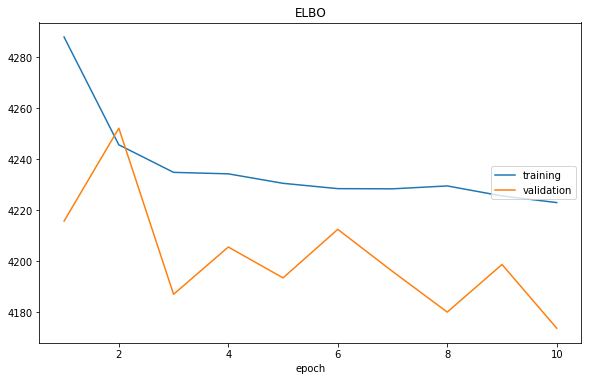

ELBO:
training   (min: 4222.919, max: 4287.965, cur: 4222.919)
validation (min: 4173.544, max: 4252.155, cur: 4173.544)

VAE->UMAP representation initialised

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='correlation',
   metric_kwds=None, min_dist=0.001, n_components=2, n_epochs=None,
   n_neighbors=50, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  15
	 1  /  15
	 2  /  15
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epoch

In [10]:
## VAE RUN
%matplotlib inline
betavae = b_VAE_model(Input1)

betavae.reduce(epochs=10, hidden_size=4, lr=1e-2, beta=5, umap_neighbours=50, umap_dist=0.001)

(25351, 2)


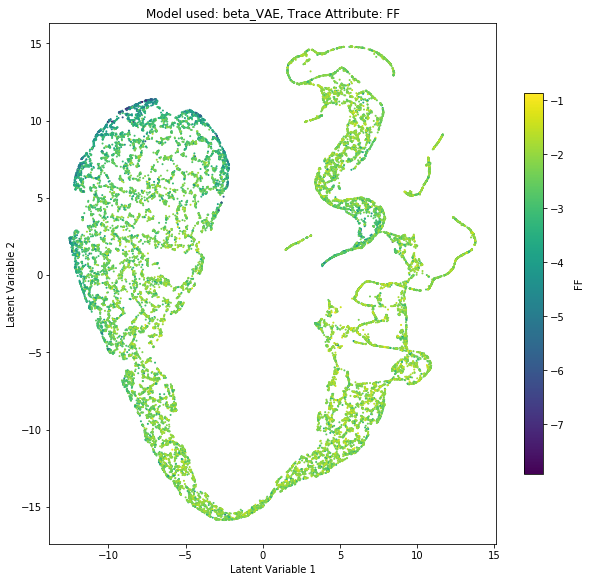

In [11]:
print(betavae.embedding.shape)
PlotAgent(betavae)
# np.save('test_cases/Flat-top12,bottom52,VAE-epochs5,latent2,lr0.01.npy', VAE_1.embedding)

In [12]:
## make a plot

# PlotAgent(VAE_1, 'horizon')

# 3. WIDGET INTERFACE:

## Widget definitions:

In [13]:
# Widget Definitions

# Data Loading:
data_files_title = widgets.HTML(
    value="<b>File Pathnames:<b>",
)

near_text = widgets.Text(description='Near SEGY:', value='./data/3d_nearstack.sgy')
far_text = widgets.Text(description='Far SEGY:', value='./data/3d_farstack.sgy')
horizon_text = widgets.Text(description='Horizon .txt:', value='./data/Top_Heimdal_subset.txt')

inline_range_title = widgets.HTML(
    value="<b>In-line range:<b>",
)

xline_range_title = widgets.HTML(
    value="<b>X-line range:<b>",
)


inline_start = widgets.IntText(
    value=1300,
    description='Start:',
    width=0.05
)

inline_stop = widgets.IntText(
    value=1502,
    description='Stop:',
)

inline_step = widgets.IntText(
    value=2,
    description='Step:',
)

xline_start = widgets.IntText(
    value=1500,
    description='Start:',
)

xline_stop = widgets.IntText(
    value=2002,
    description='Stop:',
)

xline_step = widgets.IntText(
    value=2,
    description='Step:',
)

load_button = widgets.Button(
    description='Load Data',)

# Data processing:
flattening_title = widgets.HTML(
    value="<b>Horizon Flattening:<b>",
)

norm_title = widgets.HTML(
    value="<b>Normalisation:<b>",
)

flat_option = widgets.Dropdown(
    options=[True, False],
    value=True,
    description='True/False:',
    disabled=False,
)

above_add = widgets.IntText(
    value=12,
    description='Above Add:',)
    
below_add = widgets.IntText(
    value=52,
    description='Below Add:',)

norm_option = widgets.Dropdown(
    options=[True, False],
    value=True,
    description='True/False:',
    disabled=False,
)

process_button = widgets.Button(
    description='Process Input',)


# Model selection:
umap_title = widgets.HTML(
    value="<b>UMAP:<b>",
)

umap_neighbours = widgets.IntText(
    value=50,
    description='Neighbours:',)

umap_dist = widgets.BoundedFloatText(
    value=1e-2,
    min = 0.0001,
    max = 1,
    step=0.0001,
    description='Min Dist:',)

umap_button = widgets.Button(
    description='Run Umap',)



vae_title = widgets.HTML(
    value="<b>VAE parameters:<b>",
)

epoch_num = widgets.IntText(
    value=3,
    min=3,
    description='Epochs:',)

latent_dim = widgets.IntText(
    value=8,
    description='Latent size:',)

learn_rate = widgets.BoundedFloatText(
    value=1e-2,
    min = 0.0001,
    max = 1,
    step=0.005,
    description='Learn Rate:',)

vae_button = widgets.Button(
    description='Run Vae',)

vumap_title = widgets.HTML(
    value="<b>VAE->UMAP 2-D parameters:<b>",
)

vumap_neighbours = widgets.IntText(
    value=50,
    description='Neighbours:',)

vumap_dist = widgets.BoundedFloatText(
    value=1e-2,
    min = 0.001,
    max = 1,
    step=0.0001,
    description='Min Dist:',)

#bvae
bvae_title = widgets.HTML(
    value="<b>beta-VAE parameters:<b>",
)

bvae_epoch_num = widgets.IntText(
    value=3,
    min=3,
    description='Epochs:',)

bvae_latent_dim = widgets.IntText(
    value=8,
    description='Latent size:',)

bvae_learn_rate = widgets.BoundedFloatText(
    value=1e-2,
    min = 0.0001,
    max = 1,
    step=0.005,
    description='Learn Rate:',)

bvae_beta = widgets.IntText(
    value=5,
    description='beta value:',)

bvae_button = widgets.Button(
    description='Run beta-vae',)

bvae_umap_title = widgets.HTML(
    value="<b>beta-VAE->UMAP 2-D parameters:<b>",
)

bvae_umap_neighbours = widgets.IntText(
    value=50,
    description='Neighbours:',)

bvae_umap_dist = widgets.BoundedFloatText(
    value=1e-2,
    min = 0.001,
    max = 1,
    step=0.0001,
    description='Min Dist:',)


# Plotting:
plot_title = widgets.HTML(
    value="<b>Plot parameters:<b>",
)


# drop down widget
attr_dropdown = widgets.Dropdown(
    options=['horizon', 'FF'],
    description='Plot Attribute:',
)

# Declare output widget
PLOToutput = widgets.Output(layout={'border': '4px solid black'})

GENERALoutput = widgets.Output(layout={'border': '4px solid red'})

clear_button = widgets.Button(description='Clear Output')

## Action/Logic Definitions:

In [14]:
# LOGIC

# Data load:
@load_button.on_click
def load_on_click(b):
    ### Client loader
    with GENERALoutput:
        clear_output()
        print('Loading SEGY: \n')
        
        dataholder = DataHolder("Data", [inline_start.value, inline_stop.value, inline_step.value], 
                                        [xline_start.value, xline_stop.value, xline_step.value])
        dataholder.add_near(near_text.value);
        dataholder.add_far(far_text.value);
        dataholder.add_horizon(horizon_text.value)
        dataholder.add_well('well_1', 36, 276//2)

        # save to binary file
        with open("./pickled/data.pickle", "wb") as file_:
            pickle.dump(dataholder, file_, -1)
        file_.close()
        print('\nData Loaded successfully!\n')

# Data process:
@process_button.on_click
def process_on_click(b):
    # load data
    file_pi2 = open('./pickled/data.pickle', 'rb')
    dataholder = pickle.load(file_pi2)
    file_pi2.close()
    
    #processing
    with GENERALoutput:
        clear_output()
        processor = Processor(dataholder)
        input1 = processor([flat_option.value, above_add.value, below_add.value], norm_option.value)
    
        # save to binary file
        with open("./pickled/input.pickle", "wb") as file_:
            pickle.dump(input1, file_, -1)
        file_.close()
        print('Data Input processed successfully')

# Run Umap
@umap_button.on_click
def run_on_click(b):
    # load input
    file_pi2 = open('./pickled/input.pickle', 'rb')
    input1 = pickle.load(file_pi2)
    file_pi2.close()
    
    with PLOToutput:
        clear_output()
    
    # UMAP RUN
    with GENERALoutput:
        clear_output()
        UMAP_a = UMAP(input1)
        UMAP_a.reduce(umap_neighbours.value)
    
    # First plot
    makeplot(UMAP_a, attr_dropdown.value)
    
    # save to binary file
    with open("./pickled/model.pickle", "wb") as file_:
        pickle.dump(UMAP_a, file_, -1)
    file_.close()
    
# Run VAE
@vae_button.on_click
def run_on_click(b):    
    # load input
    file_pi2 = open('./pickled/input.pickle', 'rb')
    input1 = pickle.load(file_pi2)
    file_pi2.close()
    
    with PLOToutput:
        clear_output()
    
    with GENERALoutput:
        %matplotlib inline
        # VAE RUN
        Vae_a = VAE_model(input1)
        Vae_a.reduce(epochs=epoch_num.value, hidden_size=latent_dim.value, lr=learn_rate.value,
                     umap_neighbours=vumap_neighbours.value, umap_dist=vumap_dist.value)

         # save to binary file
        with open("./pickled/model.pickle", "wb") as file_:
            pickle.dump(Vae_a, file_, -1)
        file_.close()
        
    
    makeplot(Vae_a, attr_dropdown.value)
    
# Run VAE
@bvae_button.on_click
def run_on_click(b):    
    # load input
    file_pi2 = open('./pickled/input.pickle', 'rb')
    input1 = pickle.load(file_pi2)
    file_pi2.close()
    
    with PLOToutput:
        clear_output()
    
    with GENERALoutput:
        %matplotlib inline
        # VAE RUN
        b_vae_a = VAE_model(input1)
        b_vae_a.reduce(epochs=bvae_epoch_num.value, hidden_size=bvae_latent_dim.value, lr=bvae_learn_rate.value,
                     umap_neighbours=bvae_umap_neighbours.value, umap_dist=bvae_umap_dist.value)

         # save to binary file
        with open("./pickled/model.pickle", "wb") as file_:
            pickle.dump(b_vae_a, file_, -1)
        file_.close()
        
    
    makeplot(b_vae_a, attr_dropdown.value)

    
@attr_dropdown.observe
def on_change(change):
    # load embedding
    file2 = open('./pickled/model.pickle', 'rb')
    model = pickle.load(file2)
    file2.close()

    # if dropdown change
    if change['type'] == 'change' and change['name'] == 'value':
#         print (change['new'])
        makeplot(model, change['new'])

    
def makeplot(model, attr):
    %matplotlib notebook
    with PLOToutput:
        clear_output()

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.set(xlabel='Latent Variable 1', ylabel='Latent Variable 2',
               title='Model used: {}, Trace Attribute: {}'.format(model.name, attr),
               aspect='equal')
        s = ax.scatter(model.embedding[:, 0], model.embedding[:, 1], s=0.5, c=model.attributes[attr])
        c = plt.colorbar(s, shrink=0.7, orientation='vertical')
        c.set_label(label=attr, rotation=90, labelpad=10)


@clear_button.on_click
def clear_it(arg):
    with GENERALoutput:
        clear_output()
    with PLOToutput:
        clear_output()

## GUI/Interface Layout Structuring

In [15]:
# GUI LAYOUT
%matplotlib notebook

# Load tab
tab1 = VBox(children=[HBox(children=[VBox(children=[data_files_title, near_text, far_text, horizon_text]), 
                                     VBox(children=[inline_range_title, inline_start, inline_stop, inline_step]),
                                     VBox(children=[xline_range_title, xline_start, xline_stop, xline_step]),
                                     ]),
                      load_button  
                     ])
                     
# processing tab
tab2 = VBox(children=[HBox(children=[VBox(children=[flattening_title, flat_option, above_add, below_add,]),
                                     VBox(children=[norm_title, norm_option])
                                    ]),     
                      process_button
                     ])

# model tab
accordion = widgets.Accordion(children=[VBox(children=[umap_neighbours, umap_dist, umap_button]), 
                                        HBox(children=[VBox(children=[vae_title, epoch_num, learn_rate, latent_dim, vae_button]),
                                                       VBox(children=[vumap_title, vumap_neighbours, vumap_dist])]),
                                        HBox(children=[VBox(children=[bvae_title, bvae_epoch_num, bvae_learn_rate, bvae_latent_dim, bvae_beta, bvae_button]),
                                                       VBox(children=[bvae_umap_title, bvae_umap_neighbours, bvae_umap_dist])])
                                       ])
accordion.set_title(0, 'UMAP')
accordion.set_title(1, 'VAE')
accordion.set_title(2, 'β-VAE')


tab3 = VBox(children=[HBox(children=[VBox(children=[]),
                                     VBox(children=[]),
                                    ]),
                      accordion
                     ])

# visualisation
tab4 = VBox(children=[HBox(children=[VBox(children=[plot_title, attr_dropdown]),
                                     VBox(children=[]),
                                    ])
                     ])


tab = widgets.Tab(children=[tab1, tab2, tab3, tab4])
tab.set_title(0, '1. Data Loading')
tab.set_title(1, '2. Data Processing')
tab.set_title(2, '3. Model Selection')
tab.set_title(3, '4. Visualisation')

VBox(children=[tab, clear_button, PLOToutput, GENERALoutput])